In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities3 import *
from Adam import Adam
from scipy import integrate
from SPNO_me_1d import *
from scipy.stats import multivariate_normal

In [2]:
x_data = np.load('data/spde_mul_x.npy')
y_data = np.load('data/spde_mul_y.npy')
eps = x_data[:,-1][:,None]

x_grid = np.linspace(0, 1, x_data.shape[-1])

ntrain = 900
ntest = 100

batch_size = 50
learning_rate = 0.001

epochs = 500
step_size = 50
gamma = 0.5

modes = 16
width = 64

x_data = x_data[:,::5]
y_data = y_data[:,::5]
x_grid = x_grid[::5]

x_data = np.concatenate((x_data,eps),-1)

x_train = x_data[:ntrain]
y_train = y_data[:ntrain]
x_test = x_data[-ntest:]
y_test = y_data[-ntest:]

In [3]:
x_train = torch.Tensor(x_train)
y_train = torch.Tensor(y_train)
x_test = torch.Tensor(x_test)
y_test = torch.Tensor(y_test)

x_train = torch.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_test = torch.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)

model = SPNO1d(modes, width, x_grid.shape[-1]).cuda()
print('Total parameters:',count_params(model))

optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

start = default_timer()

MSE = torch.zeros(epochs)
L2 = torch.zeros(epochs)

myloss = LpLoss(size_average=False)
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x)
        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
        l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward()
        
        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()
        
    scheduler.step()
    
    train_mse /= len(train_loader)
    train_l2 /= ntrain
    t2 = default_timer()
    
    MSE[ep] = train_mse
    L2[ep] = train_l2
    print('\repoch {:d}/{:d} L2 = {:.6f}, MSE = {:.6f}, using {:.6f}s'.format(ep+1,epochs,train_l2,train_mse,t2-t1), end='\n', flush=True)

print('Total training time:',default_timer()-start,'s')

Total parameters: 1464842
epoch 1/500 L2 = 1.203546, MSE = 0.300348, using 3.648235s
epoch 2/500 L2 = 0.412895, MSE = 0.027763, using 0.625440s
epoch 3/500 L2 = 0.212085, MSE = 0.005841, using 0.630718s
epoch 4/500 L2 = 0.157633, MSE = 0.003469, using 0.616202s
epoch 5/500 L2 = 0.140567, MSE = 0.002508, using 0.619457s
epoch 6/500 L2 = 0.119743, MSE = 0.002114, using 0.620013s
epoch 7/500 L2 = 0.123384, MSE = 0.002506, using 0.620675s
epoch 8/500 L2 = 0.110439, MSE = 0.001633, using 0.629487s
epoch 9/500 L2 = 0.076653, MSE = 0.000753, using 0.619971s
epoch 10/500 L2 = 0.075468, MSE = 0.000726, using 0.631296s
epoch 11/500 L2 = 0.130392, MSE = 0.002914, using 0.631595s
epoch 12/500 L2 = 0.089243, MSE = 0.001180, using 0.636012s
epoch 13/500 L2 = 0.077433, MSE = 0.000799, using 0.622187s
epoch 14/500 L2 = 0.087427, MSE = 0.000908, using 0.615316s
epoch 15/500 L2 = 0.063220, MSE = 0.000601, using 0.638769s
epoch 16/500 L2 = 0.064121, MSE = 0.000583, using 0.623628s
epoch 17/500 L2 = 0.060

epoch 137/500 L2 = 0.014625, MSE = 0.000020, using 0.373817s
epoch 138/500 L2 = 0.011730, MSE = 0.000013, using 0.374104s
epoch 139/500 L2 = 0.011119, MSE = 0.000010, using 0.370547s
epoch 140/500 L2 = 0.012993, MSE = 0.000015, using 0.371802s
epoch 141/500 L2 = 0.014083, MSE = 0.000020, using 0.370141s
epoch 142/500 L2 = 0.013165, MSE = 0.000016, using 0.371965s
epoch 143/500 L2 = 0.011304, MSE = 0.000010, using 0.378621s
epoch 144/500 L2 = 0.011651, MSE = 0.000011, using 0.377392s
epoch 145/500 L2 = 0.013601, MSE = 0.000017, using 0.379260s
epoch 146/500 L2 = 0.012878, MSE = 0.000014, using 0.375765s
epoch 147/500 L2 = 0.011751, MSE = 0.000010, using 0.373462s
epoch 148/500 L2 = 0.014405, MSE = 0.000023, using 0.373845s
epoch 149/500 L2 = 0.015544, MSE = 0.000037, using 0.374571s
epoch 150/500 L2 = 0.015383, MSE = 0.000022, using 0.374636s
epoch 151/500 L2 = 0.011412, MSE = 0.000011, using 0.372987s
epoch 152/500 L2 = 0.010849, MSE = 0.000011, using 0.369616s
epoch 153/500 L2 = 0.008

epoch 272/500 L2 = 0.006249, MSE = 0.000002, using 0.371928s
epoch 273/500 L2 = 0.006495, MSE = 0.000003, using 0.374390s
epoch 274/500 L2 = 0.006518, MSE = 0.000003, using 0.371233s
epoch 275/500 L2 = 0.006081, MSE = 0.000002, using 0.369893s
epoch 276/500 L2 = 0.006230, MSE = 0.000002, using 0.371631s
epoch 277/500 L2 = 0.006566, MSE = 0.000003, using 0.373469s
epoch 278/500 L2 = 0.006448, MSE = 0.000003, using 0.372712s
epoch 279/500 L2 = 0.006298, MSE = 0.000003, using 0.377609s
epoch 280/500 L2 = 0.006139, MSE = 0.000002, using 0.381397s
epoch 281/500 L2 = 0.006285, MSE = 0.000002, using 0.375856s
epoch 282/500 L2 = 0.006130, MSE = 0.000002, using 0.374010s
epoch 283/500 L2 = 0.006016, MSE = 0.000002, using 0.372623s
epoch 284/500 L2 = 0.006009, MSE = 0.000002, using 0.368914s
epoch 285/500 L2 = 0.005944, MSE = 0.000002, using 0.371808s
epoch 286/500 L2 = 0.006202, MSE = 0.000002, using 0.370871s
epoch 287/500 L2 = 0.006166, MSE = 0.000002, using 0.368098s
epoch 288/500 L2 = 0.005

epoch 407/500 L2 = 0.005361, MSE = 0.000002, using 0.370035s
epoch 408/500 L2 = 0.005348, MSE = 0.000002, using 0.371357s
epoch 409/500 L2 = 0.005334, MSE = 0.000002, using 0.372618s
epoch 410/500 L2 = 0.005363, MSE = 0.000002, using 0.371328s
epoch 411/500 L2 = 0.005343, MSE = 0.000002, using 0.370550s
epoch 412/500 L2 = 0.005332, MSE = 0.000002, using 0.375048s
epoch 413/500 L2 = 0.005363, MSE = 0.000002, using 0.371358s
epoch 414/500 L2 = 0.005368, MSE = 0.000002, using 0.373109s
epoch 415/500 L2 = 0.005338, MSE = 0.000002, using 0.372041s
epoch 416/500 L2 = 0.005307, MSE = 0.000002, using 0.372413s
epoch 417/500 L2 = 0.005316, MSE = 0.000002, using 0.371367s
epoch 418/500 L2 = 0.005334, MSE = 0.000002, using 0.375955s
epoch 419/500 L2 = 0.005337, MSE = 0.000002, using 0.375086s
epoch 420/500 L2 = 0.005336, MSE = 0.000002, using 0.375348s
epoch 421/500 L2 = 0.005315, MSE = 0.000002, using 0.374240s
epoch 422/500 L2 = 0.005322, MSE = 0.000002, using 0.374013s
epoch 423/500 L2 = 0.005

In [4]:
pred = torch.zeros(y_test.shape)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=1, shuffle=False)
index = 0
test_l2 = 0
test_mse = 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.cuda(), y.cuda()

        out = model(x).view(-1)
        pred[index] = out
        mse = F.mse_loss(out.view(1, -1), y.view(1, -1), reduction='mean')
        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        test_mse += mse.item()
        index += 1
        
    test_mse /= len(test_loader)
    test_l2 /= ntest
    print('test error: L2 =', test_l2,', MSE =',test_mse)

test error: L2 = 0.00636356293107383 , MSE = 2.269979774784936e-06


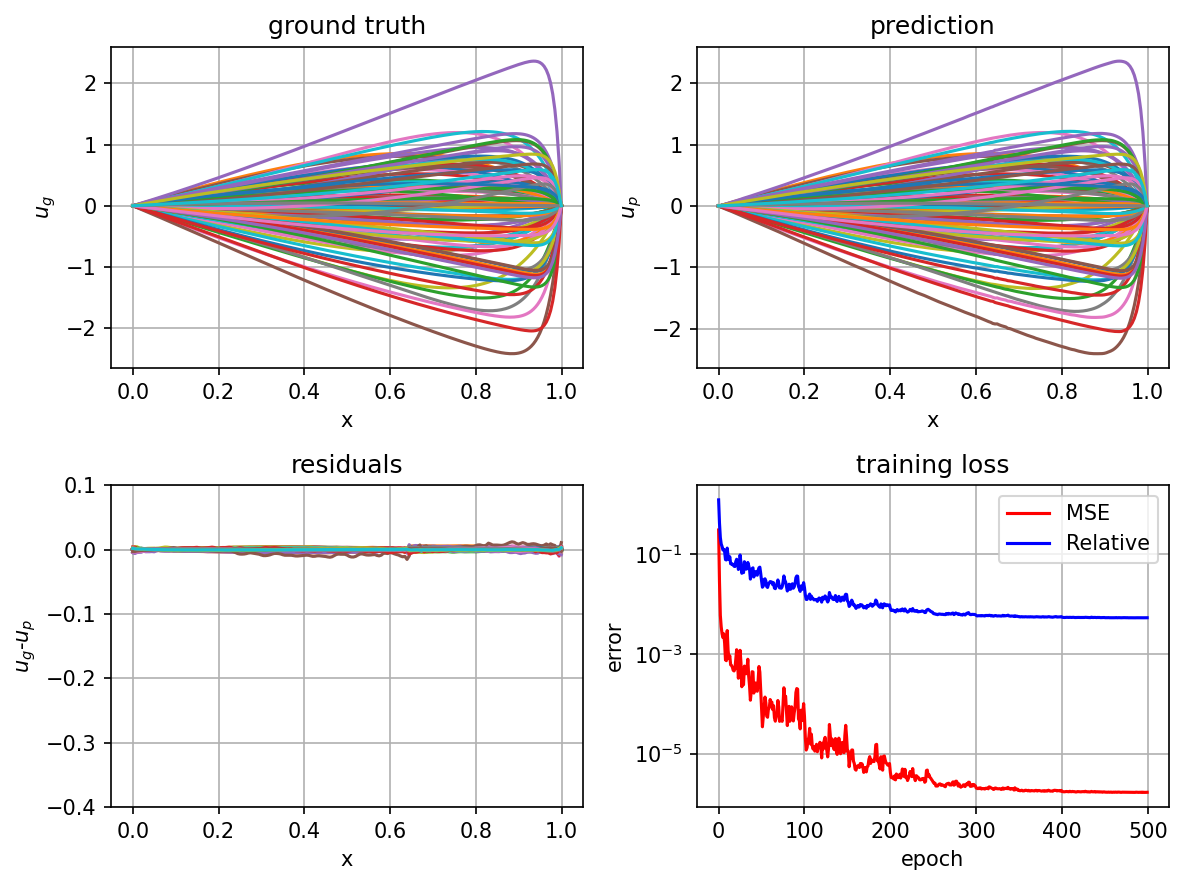

In [5]:
residual = pred-y_test
fig = plt.figure(figsize=(8,6),dpi=150)

plt.subplot(2,2,1)
plt.title("ground truth")
for i in range(ntest):
    plt.plot(x_grid,y_test[i])
plt.xlabel("x")
plt.ylabel("$u_g$")
plt.grid()

plt.subplot(2,2,2)
plt.title("prediction")
for i in range(ntest):
    plt.plot(x_grid,pred[i])
plt.xlabel("x")
plt.ylabel("$u_p$")
plt.grid()

plt.subplot(2,2,3)
plt.title("residuals")
plt.ylim([-0.4,0.1])
for i in range(ntest):
    plt.plot(x_grid,residual[i])
plt.xlabel("x")
plt.ylabel("$u_g$-$u_p$")
plt.grid()
    
plt.subplot(2,2,4)
plt.title("training loss")
plt.plot(MSE,c='r',label='MSE')
plt.plot(L2,c='b',label='Relative')
plt.legend()
plt.yscale('log')
plt.xlabel("epoch")
plt.ylabel("error")
plt.grid()

plt.tight_layout()
plt.show()

In [6]:
v = torch.zeros(ntest)
m = torch.zeros(ntest)
for i in range(ntest):
    v[i] = torch.var(residual[i],unbiased=False)
    m[i] = torch.mean(residual[i])
print(torch.mean(m),torch.mean(v))

tensor(8.2994e-05) tensor(1.9027e-06)


In [7]:
mse = MSE.numpy().reshape(1,MSE.shape[0])
l2 = L2.numpy().reshape(1,L2.shape[0])
loss = np.concatenate((mse,l2))
np.save("data/spno_loss_mul.npy",loss)
torch.save(model,"model/spno_mul")